In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers

2023-11-22 20:05:02.787763: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-22 20:05:03.404986: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-22 20:05:03.469812: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-11-22 20:05:03.469830: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

x_train = x_train.astype("float32") / 255.0
x_train = np.reshape(x_train, (-1, 28, 28, 1))
y_train = tf.one_hot(y_train, 10)

x_test = x_test.astype("float32") / 255.0
x_test = np.reshape(x_test, (-1, 28, 28, 1))
y_test = tf.one_hot(y_test, 10)

4422102/4422102 [==============================] - 1s 0us/step


2023-11-22 20:05:17.793497: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-11-22 20:05:17.797759: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-11-22 20:05:17.797786: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (edmond-Inspiron-13-5310): /proc/driver/nvidia/version does not exist
2023-11-22 20:05:17.811032: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
AUTO = tf.data.AUTOTUNE
BATCH_SIZE = 64
EPOCHS = 10

In [4]:
# Put aside a few samples to create our validation set
val_samples = 2000
x_val, y_val = x_train[:val_samples], y_train[:val_samples]
new_x_train, new_y_train = x_train[val_samples:], y_train[val_samples:]

train_ds_one = (
    tf.data.Dataset.from_tensor_slices((new_x_train, new_y_train))
    .shuffle(BATCH_SIZE * 100)
    .batch(BATCH_SIZE)
)
train_ds_two = (
    tf.data.Dataset.from_tensor_slices((new_x_train, new_y_train))
    .shuffle(BATCH_SIZE * 100)
    .batch(BATCH_SIZE)
)
# Because we will be mixing up the images and their corresponding labels, we will be
# combining two shuffled datasets from the same training data.
train_ds = tf.data.Dataset.zip((train_ds_one, train_ds_two))

val_ds = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(BATCH_SIZE)

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(BATCH_SIZE)

In [18]:
def sample_beta_distribution(size, concentration_0=0.2, concentration_1=0.2):
    gamma_1_sample = tf.random.gamma(shape=[size], alpha=concentration_1)
    gamma_2_sample = tf.random.gamma(shape=[size], alpha=concentration_0)
    return gamma_1_sample / (gamma_1_sample + gamma_2_sample)


def mix_up(ds_one, ds_two, alpha=0.2):
    # Unpack two datasets
    images_one, labels_one = ds_one
    images_two, labels_two = ds_two
    batch_size = tf.shape(images_one)[0]

    # Sample lambda and reshape it to do the mixup
    l = sample_beta_distribution(batch_size, alpha, alpha)
    x_l = tf.reshape(l, (batch_size, 1, 1, 1))
    y_l = tf.reshape(l, (batch_size, 1))

    # Perform mixup on both images and labels by combining a pair of images/labels
    # (one from each dataset) into one image/label
    images = images_one * x_l + images_two * (1 - x_l)
    labels = labels_one * y_l + labels_two * (1 - y_l)
    return (images, labels)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.310677336936351e-05, 0.0, 0.9999768733978271, 0.0]
[0.04768514633178711, 0.0, 0.0, 0.0, 0.9523148536682129, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.8884774446487427, 0.0, 0.11152255535125732, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.9575706720352173, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.042429327964782715, 0.0]
[0.0, 0.0, 0.07957660406827927, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9204233884811401]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.6695352792739868, 0.0, 0.0, 0.0, 0.3304647207260132]
[0.0, 0.0, 0.0, 0.03627486154437065, 0.0, 0.0, 0.0, 0.9637251496315002, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5505000352859497, 0.4494999647140503]


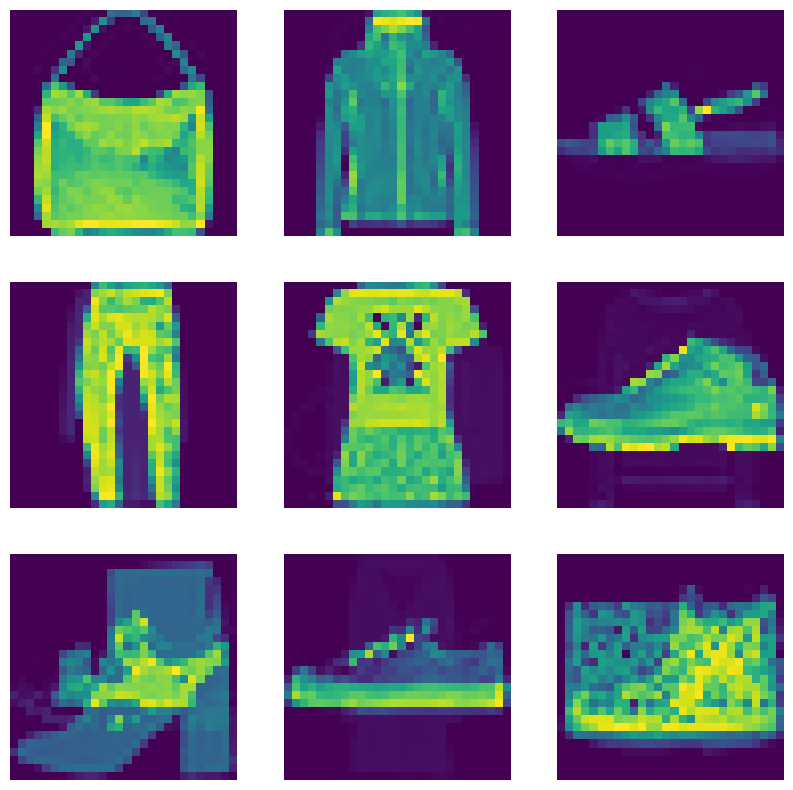

In [19]:
# First create the new dataset using our `mix_up` utility
train_ds_mu = train_ds.map(
    lambda ds_one, ds_two: mix_up(ds_one, ds_two, alpha=0.2), num_parallel_calls=-1
)

# Let's preview 9 samples from the dataset
sample_images, sample_labels = next(iter(train_ds_mu))
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(zip(sample_images[:9], sample_labels[:9])):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().squeeze())
    print(label.numpy().tolist())
    plt.axis("off")

In [20]:
def get_training_model():
    model = tf.keras.Sequential(
        [
            layers.Conv2D(16, (5, 5), activation="relu", input_shape=(28, 28, 1)),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Conv2D(32, (5, 5), activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Dropout(0.2),
            layers.GlobalAvgPool2D(),
            layers.Dense(128, activation="relu"),
            layers.Dense(10, activation="softmax"),
        ]
    )
    return model

In [21]:
initial_model = get_training_model()
initial_model.save_weights("initial_weights.h5")

In [22]:
model = get_training_model()
model.load_weights("initial_weights.h5")
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.fit(train_ds_mu, validation_data=val_ds, epochs=EPOCHS)
_, test_acc = model.evaluate(test_ds)
print("Test accuracy: {:.2f}%".format(test_acc * 100))

Epoch 1/10
907/907 [==============================] - 7s 7ms/step - loss: 1.1997 - accuracy: 0.6268 - val_loss: 0.7109 - val_accuracy: 0.7500
Epoch 2/10
907/907 [==============================] - 6s 6ms/step - loss: 0.9440 - accuracy: 0.7281 - val_loss: 0.5673 - val_accuracy: 0.8010
Epoch 3/10
907/907 [==============================] - 6s 6ms/step - loss: 0.8696 - accuracy: 0.7623 - val_loss: 0.4967 - val_accuracy: 0.8310
Epoch 4/10
907/907 [==============================] - 6s 6ms/step - loss: 0.8196 - accuracy: 0.7843 - val_loss: 0.4792 - val_accuracy: 0.8410
Epoch 5/10
907/907 [==============================] - 6s 6ms/step - loss: 0.7896 - accuracy: 0.7947 - val_loss: 0.4228 - val_accuracy: 0.8565
Epoch 6/10
907/907 [==============================] - 6s 6ms/step - loss: 0.7591 - accuracy: 0.8068 - val_loss: 0.4223 - val_accuracy: 0.8580
Epoch 7/10
907/907 [==============================] - 6s 6ms/step - loss: 0.7412 - accuracy: 0.8132 - val_loss: 0.3912 - val_accuracy: 0.8680
Epoch 

In [23]:
model = get_training_model()
model.load_weights("initial_weights.h5")
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
# Notice that we are NOT using the mixed up dataset here
model.fit(train_ds_one, validation_data=val_ds, epochs=EPOCHS)
_, test_acc = model.evaluate(test_ds)
print("Test accuracy: {:.2f}%".format(test_acc * 100))

Epoch 1/10
907/907 [==============================] - 7s 6ms/step - loss: 0.8916 - accuracy: 0.6690 - val_loss: 0.6418 - val_accuracy: 0.7655
Epoch 2/10
907/907 [==============================] - 6s 6ms/step - loss: 0.6311 - accuracy: 0.7610 - val_loss: 0.5633 - val_accuracy: 0.7895
Epoch 3/10
907/907 [==============================] - 6s 6ms/step - loss: 0.5514 - accuracy: 0.7966 - val_loss: 0.4759 - val_accuracy: 0.8370
Epoch 4/10
907/907 [==============================] - 6s 6ms/step - loss: 0.4936 - accuracy: 0.8197 - val_loss: 0.4632 - val_accuracy: 0.8355
Epoch 5/10
907/907 [==============================] - 6s 6ms/step - loss: 0.4586 - accuracy: 0.8340 - val_loss: 0.4013 - val_accuracy: 0.8570
Epoch 6/10
907/907 [==============================] - 6s 6ms/step - loss: 0.4289 - accuracy: 0.8443 - val_loss: 0.3955 - val_accuracy: 0.8590
Epoch 7/10
907/907 [==============================] - 6s 6ms/step - loss: 0.4074 - accuracy: 0.8531 - val_loss: 0.3698 - val_accuracy: 0.8630
Epoch 